# Исследование бизнес-показателей интернет-магазина для увеличения выручки

### Краткое описание исследования

Мы вместе с отделом маркетинга подготовили список гипотез для увеличения выручки.\
Нам необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать полученные результаты.

**Описание данных:**\
гипотезы: `/datasets/hypothesis.csv`:
* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

заказы пользователей интернет-магазина: `/datasets/orders.csv`:
* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.

посещениях пользователями интернет-магазина: `/datasets/visitors.csv`:
* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста

**Ход исследования:**
1) предобработка данных;
2) приоритизировать гипотезы по увеличению выручки интернет-магазина с помощью методов RICE и ICE;\
3) анализ результатов А/В-теста с выводами и предположениями:
- построение графиков:\
  кумулятивной выручки по группам,  
  среднего чека по группам,\
  точечного графика количества заказов по пользователям
- расчет статистической значимость различий:\
  в среднем количестве заказов на посетителя между группами по «сырым» данным,\
  в среднем количестве заказов на посетителя между группами по «очищенным» данным,\
  в среднем чеке заказа между группами по «очищенным» данным
- итоговое решение по результатам теста (остановить тест/продолжить тет)

**Цель исследования**\
Принять решение по результатам теста и дать необходимые рекомендации.\
Варианты решений:
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.

### Загрузка данных и подготовка их к анализу

In [1]:
# импорт библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime as dt
import scipy.stats as stats
import warnings
from scipy import stats as st

In [2]:
# выгрузка файлов с данными + создание датафреймов

try:
    hypothesis, orders, visitors = (
        pd.read_csv('/datasets/hypothesis.csv'),
        pd.read_csv('/datasets/orders.csv'),
        pd.read_csv('/datasets/visitors.csv')
    )


except:
    hypothesis, orders, visitors = (
        pd.read_csv('hypothesis.csv'),
        pd.read_csv('orders.csv'),
        pd.read_csv('visitors.csv')
    )

In [3]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [5]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


#### Приведение наименования столбцов к нижнему регистру

In [6]:
# переименуем столбцы hypothesis
hypothesis.columns = [x.lower() for x in hypothesis.columns.values]

In [7]:
# переименуем столбцы orders
orders.columns = orders.columns.str.replace('Id', '_id')

#### Преобразование данных о времени к типу datetime

In [8]:
# преобразование данных о времени orders
orders['date'] = pd.to_datetime(orders['date'])

In [9]:
# преобразование данных о времени visitors
visitors['date'] = pd.to_datetime(visitors['date'])

In [10]:
# check
hypothesis.info()
print('-' * 100)
orders.info()
print('-' * 100)
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object   

Вывод:
- наименования столбцов приведены к нижнему регистру,
- столбцы с датами приведены к типу datetime.

#### Проверка дубликатов в данных

In [11]:
hypothesis.duplicated().sum(),orders.duplicated().sum(),visitors.duplicated().sum()

(0, 0, 0)

Вывод: явные дубликаты отсутствуют.

#### Установка отображения таблиц в проекте

In [12]:
# отображение всех столбцов в датафреймах
pd.set_option('display.max_columns', None)

In [13]:
# устанавливаем max ширину столбцов в таблицах
pd.set_option('max_colwidth', 1)

In [14]:
print(f'Информация о гипотезах')
display(hypothesis.head())

print(f'Информация о заказах')
display(orders.head())

print(f'Информация о посетителях')
display(visitors.head())

Информация о гипотезах


,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


Информация о заказах


,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Информация о посетителях


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Вывод: данные отображаются корректно.

### Приоритизация гипотез

#### Примение фреймворка ICE для приоритизации гипотез + сортировка по убыванию их приоритета.

In [15]:
hypothesis['ICE'] = round(hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'], 2)

In [16]:
# сортировка гипотез по убыванию приоритета
hypothesis = hypothesis.sort_values(by='ICE', ascending=False)

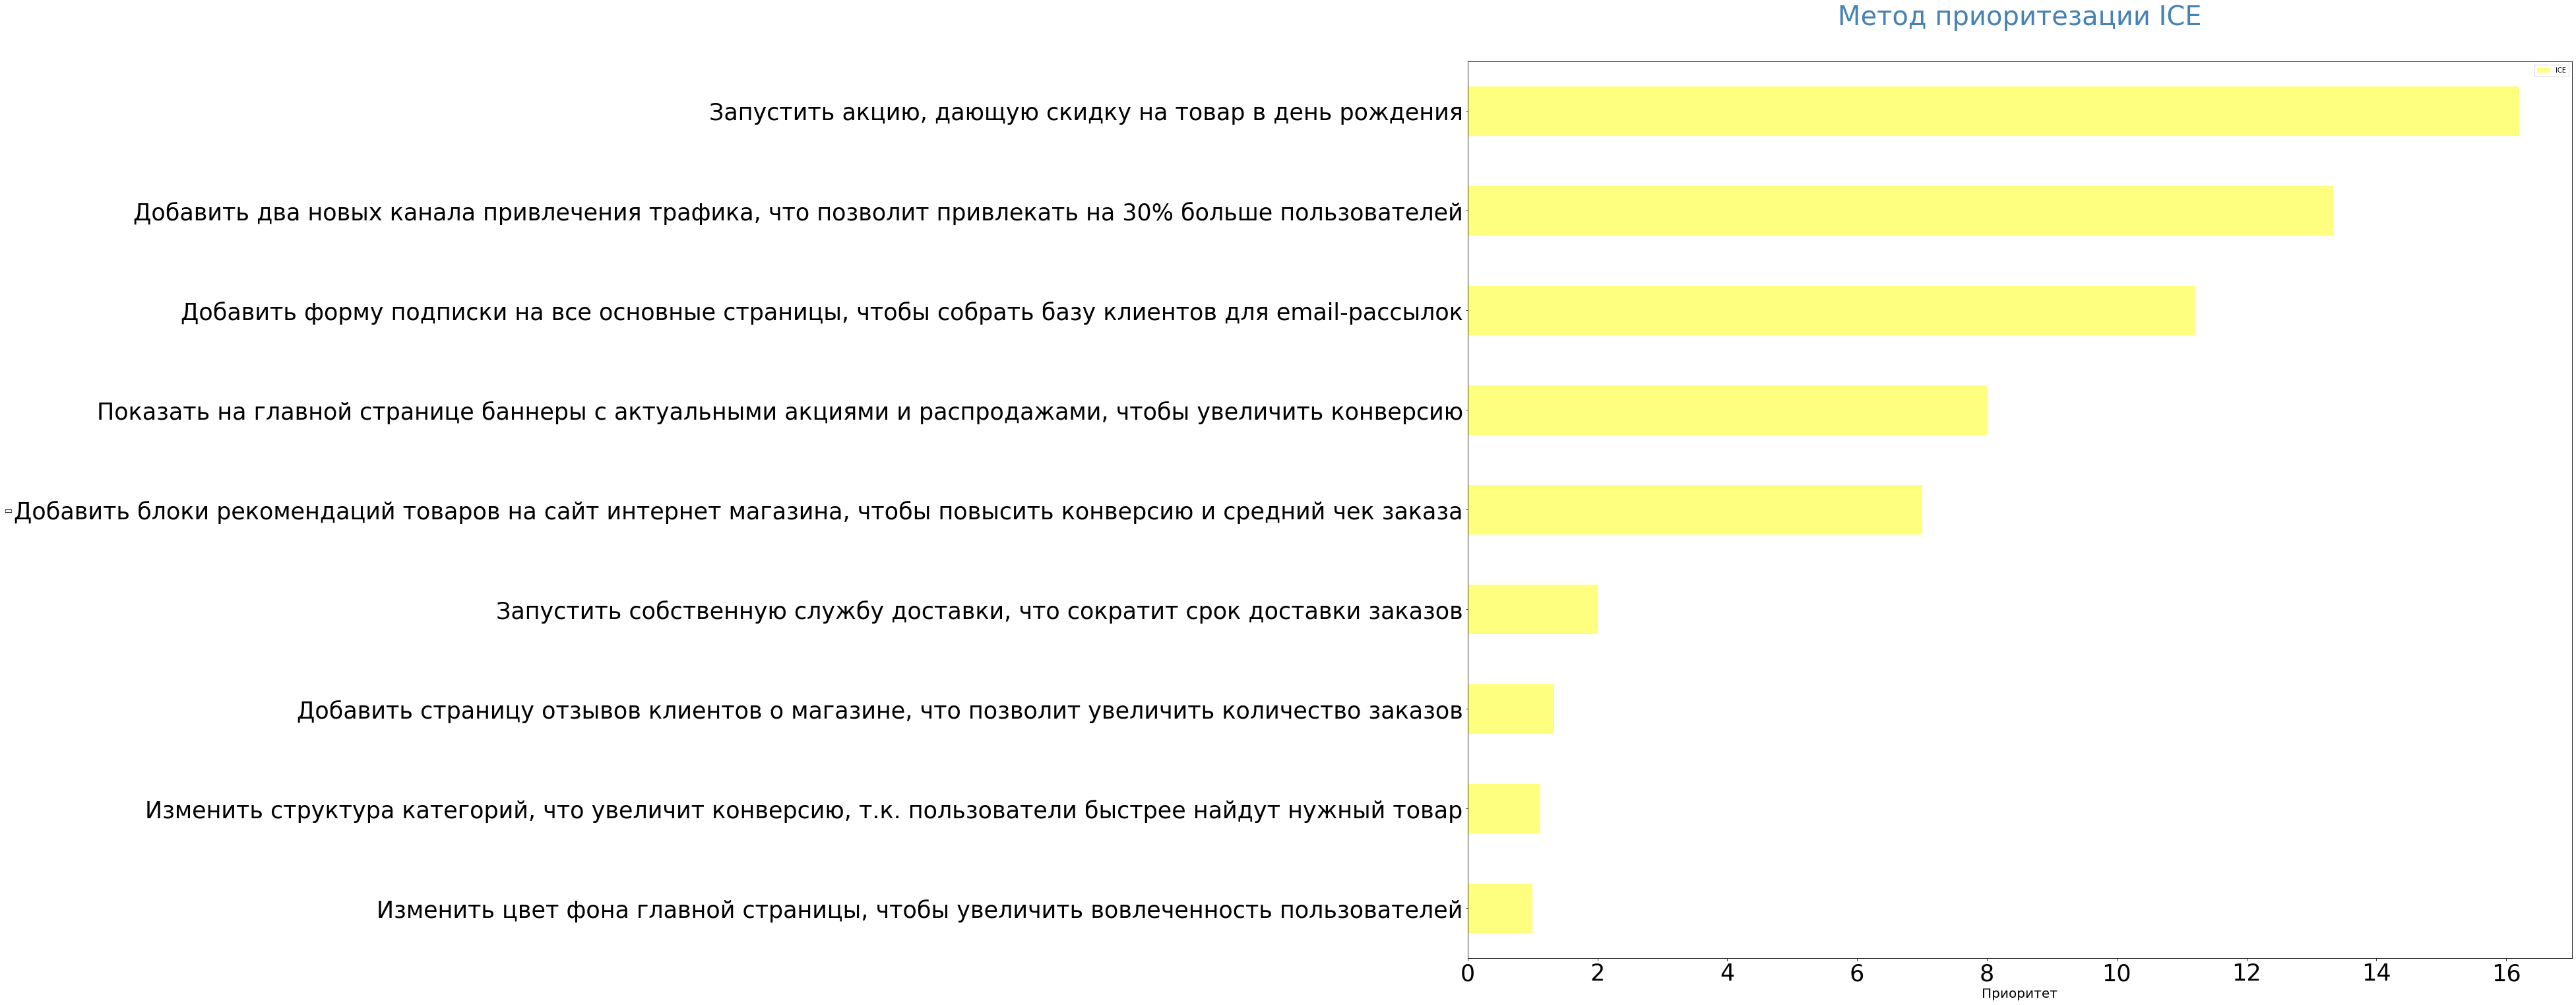

In [17]:
(
    hypothesis[['hypothesis', 'ICE']]
    .sort_values(by='ICE')
    .plot(x='hypothesis', kind = 'barh', figsize = (30,25), legend = True, fontsize = 35,
          alpha=.5, color=['#FFFF00'])
    .set_title('Метод приоритезации ICE' + "\n", fontsize = 40, color = 'SteelBlue')

);

plt.ylabel([]);
plt.xlabel('Приоритет', fontsize = 20);

Наиболее перспективными являются гипотезы (ТОП-3):
1. Запустить акцию, дающую скидку на товар в день рождения,
2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей,
3. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

Приоритет остальных гипотез ниже минимум на 30% от ТОП-3.

#### Примение фреймворка RICE для приоритизации гипотез + сортировка по убыванию их приоритета.

In [18]:
hypothesis['RICE'] = round(hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'], 2)

In [19]:
# сортировка гипотез по убыванию приоритета
hypothesis = hypothesis.sort_values(by='RICE', ascending=False)

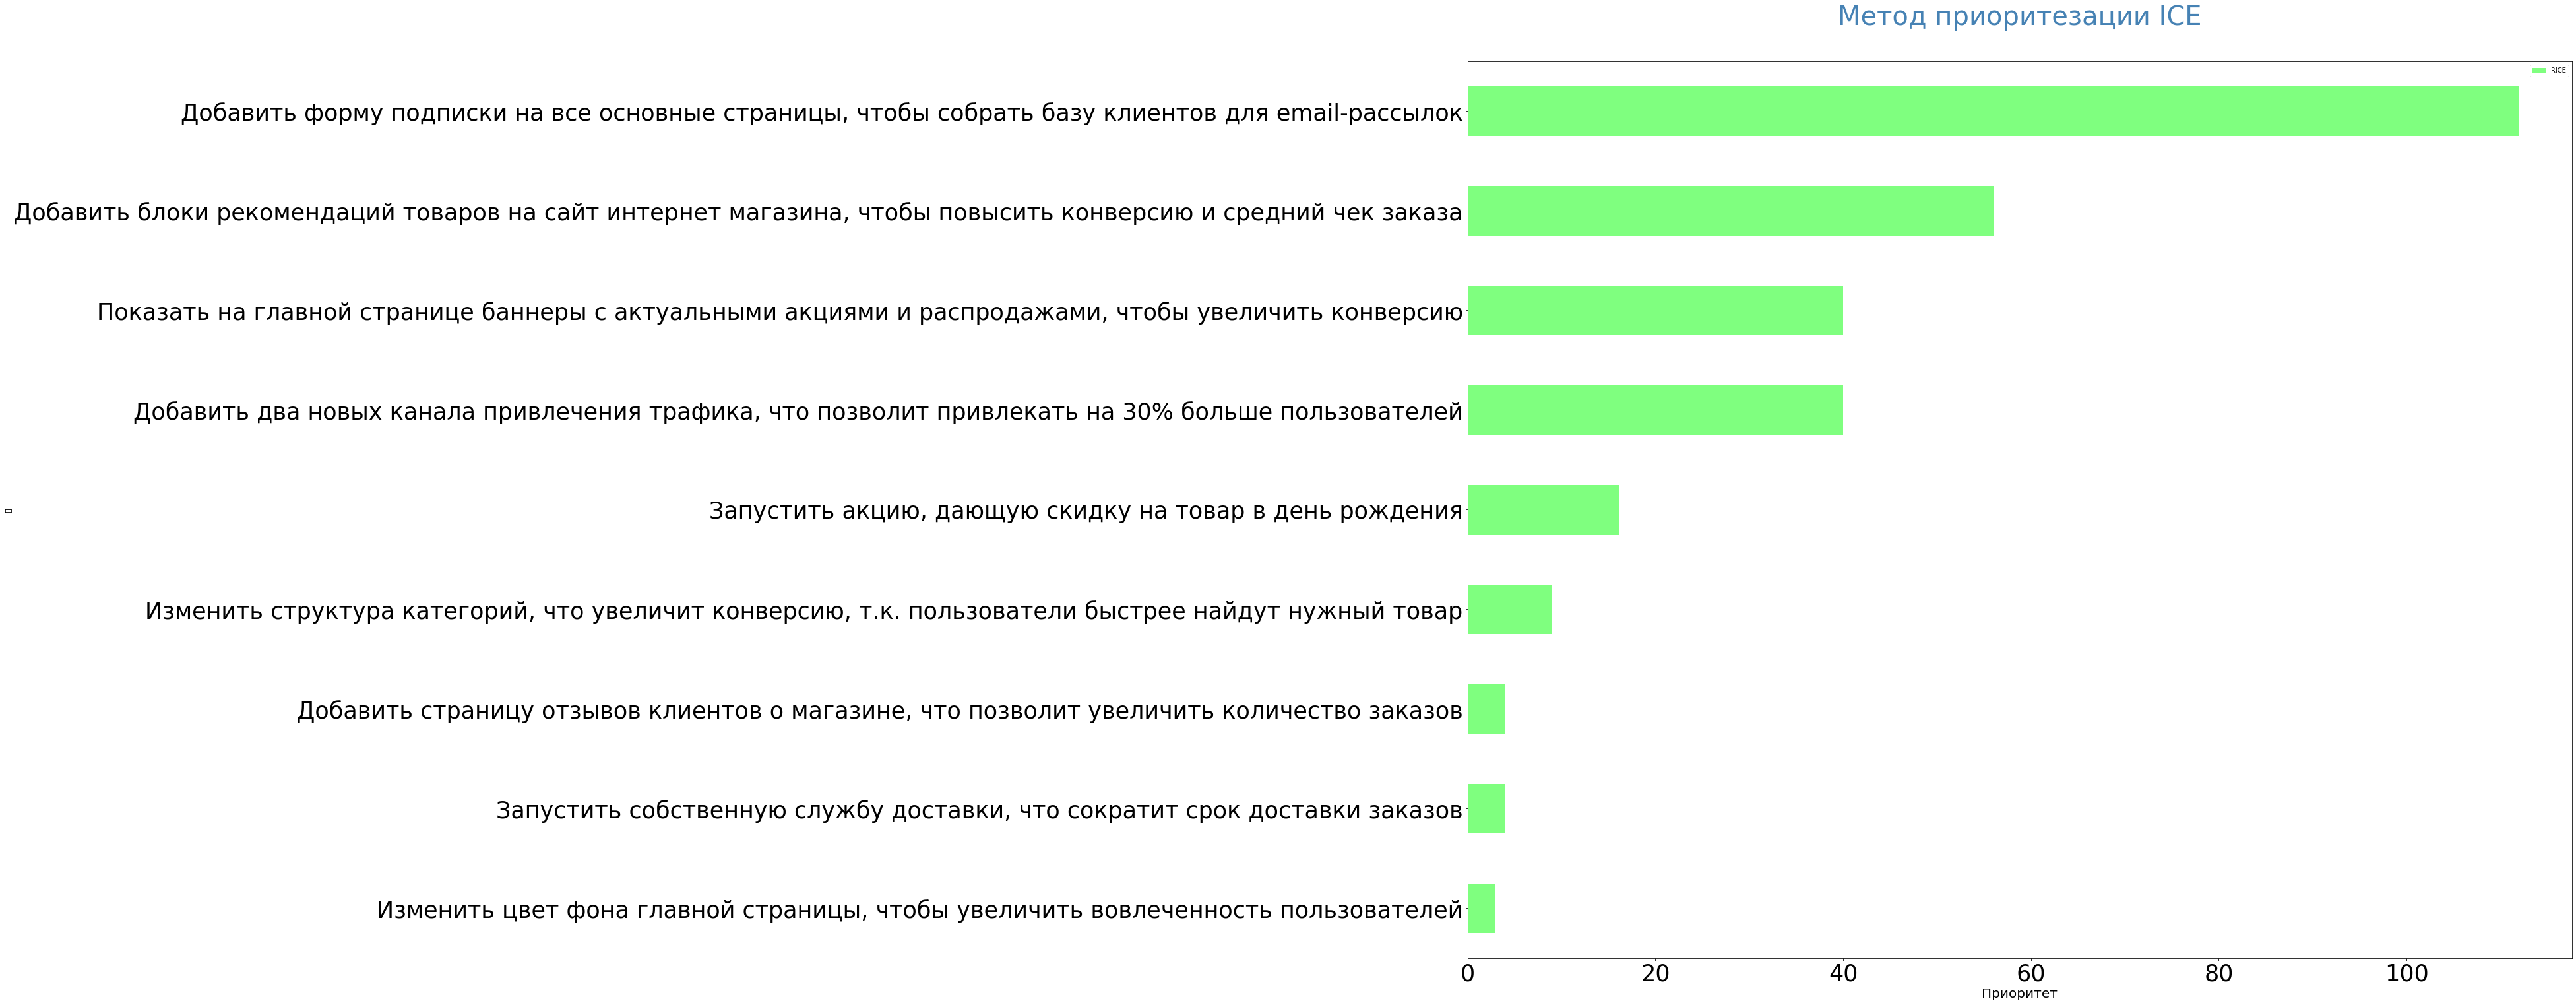

In [20]:
(
    hypothesis[['hypothesis', 'RICE']]
    .sort_values(by='RICE')
    .plot(x='hypothesis', kind = 'barh', figsize = (30,25), legend = True, fontsize = 35,
          alpha=.5, color=['#00FF00'])
    .set_title('Метод приоритезации ICE' + "\n", fontsize = 40, color = 'SteelBlue')

);

plt.ylabel([]);
plt.xlabel('Приоритет', fontsize = 20);

Наиболее перспективными являются гипотезы (ТОП-3):
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок,
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа	,
3. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию,
4. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.
*Приоритеты гипотез в п.3 и п.4 равны.*

Приоритет остальных гипотез отстают от ТОП-3 гипотез минимум на 60%.

#### Анализ изменения приоритизации гипотез при применении RICE вместо ICE

При применении метода *RICE* вместо *ICE*, приоритезация гипотез существенно изменилась.\
Причина отличия приоритетов в том, что метод RICE предполагает оценку охвата, т.е. предполагаемой целевой аудитории проекта.\
При применении метода *ICE* одна и та же гипотеза может оцениваться по-разному всеми членами команды. Что немало важно, гипотеза также может оцениваться по-разному одним и тем же лицом в разное время.

### Анализ A/B-теста

#### Исключение пользователей, которые попали одновременно в группу А и В

In [21]:
# создадит таблицу с id пользователей, которые попали одновременно в группу А и В
double = (
    orders
    .groupby('visitor_id').agg({'group': 'nunique'})
    .reset_index()
    .query('group > 1')
)

In [22]:
# выведем список пользователей, которые попали одновременно в группу А и В
double = double['visitor_id'].unique()
double

array([   8300375,  199603092,  232979603,  237748145,  276558944,
        351125977,  393266494,  457167155,  471551937,  477780734,
        818047933,  963407295, 1230306981, 1294878855, 1316129916,
       1333886533, 1404934699, 1602967004, 1614305549, 1648269707,
       1668030113, 1738359350, 1801183820, 1959144690, 2038680547,
       2044997962, 2378935119, 2458001652, 2579882178, 2587333274,
       2600415354, 2654030115, 2686716486, 2712142231, 2716752286,
       2780786433, 2927087541, 2949041841, 2954449915, 3062433592,
       3202540741, 3234906277, 3656415546, 3717692402, 3766097110,
       3803269165, 3891541246, 3941795274, 3951559397, 3957174400,
       3963646447, 3972127743, 3984495233, 4069496402, 4120364173,
       4186807279, 4256040402, 4266935830])

In [23]:
print(f"Всего выявлено {len(double)} пользователей, которые попали одновременно в обе группы.\
\nВсего пользователей в таблице orders {len(orders['visitor_id'].unique())}.")

Всего выявлено 58 пользователей, которые попали одновременно в обе группы.
Всего пользователей в таблице orders 1031.


In [24]:
print(f"Пользователи, попавшие в обе группы {round((len(double) / len(orders['visitor_id'].unique())) *100, 2)}% \
от общего количества пользователей => исключим их из таблицы orders.")

Пользователи, попавшие в обе группы 5.63% от общего количества пользователей => исключим их из таблицы orders.


In [25]:
orders = orders.query('visitor_id not in @double')

In [26]:
print(f"Мы удалили {round((1 - len(orders) / 1197) * 100, 2)}% записей.\
Удаление записей необходимо, т.к. может повлиять на результат теста.")

Мы удалили 15.12% записей.Удаление записей необходимо, т.к. может повлиять на результат теста.


Пользователи, которые попали одновременно в две группы могут исказить результат теста. Если пользователь видит разные версии в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.

####  Кумулятивные данные по дням о заказах и о посетителях интернет-магазина

Создадим массив уникальных пар значений дат и групп теста:

In [27]:
datesGroups = orders[['date','group']].drop_duplicates() 

Соберём агрегированные кумулятивные данные о заказах по дням:

In [28]:
ordersAggregated = (
    datesGroups
    .apply(
        lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
        .agg(
            {
                'date' : 'max', 
                'group' : 'max', 
                'transaction_id' : 'nunique', 
                'visitor_id' : 'nunique', 
                'revenue' : 'sum'
            }
        ), axis=1)
    .sort_values(by=['date','group'])
)

Аналогично получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина: 

In [29]:
visitorsAggregated = (
    datesGroups
    .apply(
        lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
        .agg(
            {
                'date' : 'max', 
                'group' : 'max', 
                'visitors' : 'sum'
            }
        ), axis = 1)
)

Объединим обе таблицы (`visitorsAggregated` и `ordersAggregated`) в одну: 

In [30]:
cumulativeData = (
    ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
)

In [31]:
cumulativeData = cumulativeData.rename(columns = {'transaction_id': 'orders', 'visitor_id': 'buyers'})
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


####  График кумулятивной выручки по группам

In [32]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

In [33]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

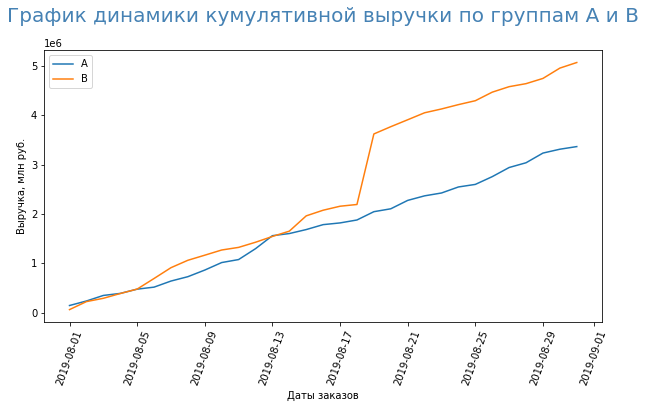

In [34]:
plt.figure(figsize=(10,5))

# график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()
plt.xticks(rotation=70)
plt.xlabel("Даты заказов")
plt.ylabel("Выручка, млн руб.")
plt.title('График динамики кумулятивной выручки по группам А и В' + "\n", fontsize = 20, color = 'SteelBlue');

Выручка группы А равномерно увеличивается в течение всего теста.\
График выручки группы В также растет в течение всего теста, однако, в нескольких точках резко растет (2019-08-18 и 2019-08-20). Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

#### График кумулятивного среднего чека по группам

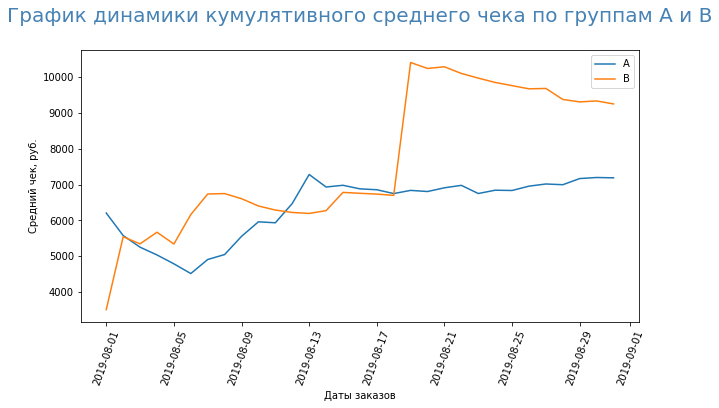

In [35]:
plt.figure(figsize=(10,5))
# разделим кумулятивную выручку на кумулятивное число заказов
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.legend()
plt.xticks(rotation=70)
plt.xlabel("Даты заказов")
plt.ylabel("Средний чек, руб.")
plt.title('График динамики кумулятивного среднего чека по группам А и В' + "\n", fontsize = 20, color = 'SteelBlue');

Средний чек тоже становится равномерным ближе к концу теста: установился для группы A и продолжает падать для группы B.
Для группы В средний чек имеет всплески в двух точках (отмечен резкий рост):
- 2019-08-18
и
- 2019-08-20

Возможно, в эти даты у группы В был всплеск числа аномально дорогих заказов в выборке.

####  График относительного изменения кумулятивного среднего чека группы B к группе A

In [36]:
# собираем данные о выручке для группы А и В в одном датафрейме
mergedCumulativeRevenue = (
    cumulativeRevenueA
    .merge(
        cumulativeRevenueB, 
        left_on='date', 
        right_on='date', 
        how='left', 
        suffixes=['A', 'B'])
)

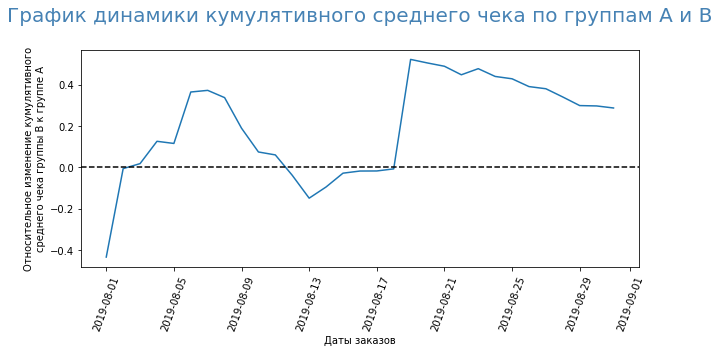

In [37]:
# cтроим отношение средних чеков
plt.figure(figsize=(10,4))

plt.plot(
    mergedCumulativeRevenue['date'], 
    (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])
    /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])
    -1
)

plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=70)
plt.xlabel("Даты заказов")
plt.ylabel("Относительное изменение кумулятивного" + "\n" + "среднего чека группы B к группе A")
plt.title('График динамики кумулятивного среднего чека по группам А и В' + "\n", fontsize = 20, color = 'SteelBlue');

В нескольких точках график различия между группами резко «скачет». Полагаем, что имеют место выбросы/крупные заказы.\
Скачки выявлены в даты:
* 2019-08-06
* 2019-08-18
* 2019-08-20

К концу теста средний чек группы В превышает чек группы А, но имеет тенденцию к снижению.

####  График кумулятивного среднего количества заказов на посетителя по группам

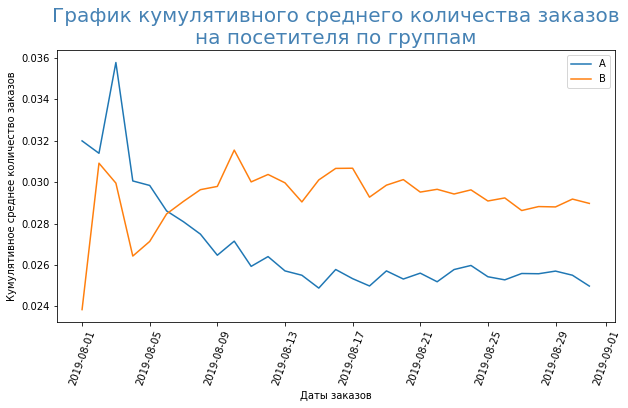

In [38]:
# считаем кумулятивное среднее количество заказов на посетителя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(10,5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.xticks(rotation=70)
plt.xlabel("Даты заказов")
plt.ylabel("Кумулятивное среднее количество заказов")
plt.title('График кумулятивного среднего количества заказов' + "\n" + 'на посетителя по группам', 
          fontsize = 20, color = 'SteelBlue');

У обеих групп наблюдаем всплески в начале теста (2019-08-02 - 2019-08-03), но затем среднее число заказов группы В фиксируется, а среднее число заказов группы А стабильно снижалось и после зафиксировалось.\
Начиная с 2019-08-06 группа В стабильно лучше группы А по данному показателю.

#### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

In [39]:
# объединим информацию о среднем количестве заказов группы А и В в одну таблицу
mergedCumulativeConversions = (
    cumulativeDataA[['date','conversion']]
    .merge(cumulativeDataB[['date','conversion']], 
           left_on='date', 
           right_on='date', 
           how='left', 
           suffixes=['A', 'B'])

)

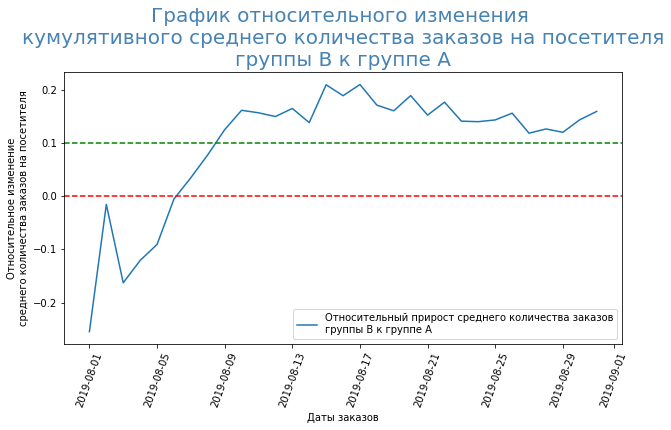

In [40]:
plt.figure(figsize=(10,5))
plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, 
         label="Относительный прирост среднего количества заказов" + "\n" + "группы B к группе A")
plt.legend()

plt.axhline(y=0, color='red', linestyle='--')
plt.axhline(y=0.1, color='green', linestyle='--')
plt.xticks(rotation=70)
plt.xlabel("Даты заказов")
plt.ylabel("Относительное изменение" + "\n" + "среднего количества заказов на посетителя")
plt.title('График относительного изменения ' + "\n"
          + 'кумулятивного среднего количества заказов на посетителя' + "\n" + 'группы B к группе A', 
          fontsize = 20, color = 'SteelBlue');

В начале теста группа B значительно проигрывала группе A, затем вырвалась вперёд. Ближе к концу теста отношение среднего количества заказов стабилизировалось (незначительная динамика 12%-14%), среднее количество заказов группы В лучше группы А ~ 15%.\
Ранее, при анализе средней выручки и средних заказов, нами были выявлены всплески, свидетельствующие о наличии выбросов.
Таким образом, нам необходимо проанализировать аномалии, возможно, они изменят картину.

#### Точечный график количества заказов по пользователям, анализ аномалий

Подсчитаем количество заказов по пользователям:

In [41]:
ordersByUsers = (
    orders
    .groupby('visitor_id')['transaction_id'].nunique()
    .reset_index()
    .sort_values(by='transaction_id', ascending=False)
    .rename(columns = {'visitor_id': 'buyers', 'transaction_id': 'orders'})
)

In [42]:
ordersByUsers.describe()

,buyers,orders
count,9.730000e+02,973.000000
mean,2.118387e+09,1.044193
std,1.221446e+09,0.238090
min,5.114589e+06,1.000000
25%,1.028756e+09,1.000000
50%,2.138109e+09,1.000000
75%,3.141508e+09,1.000000
max,4.283872e+09,3.000000


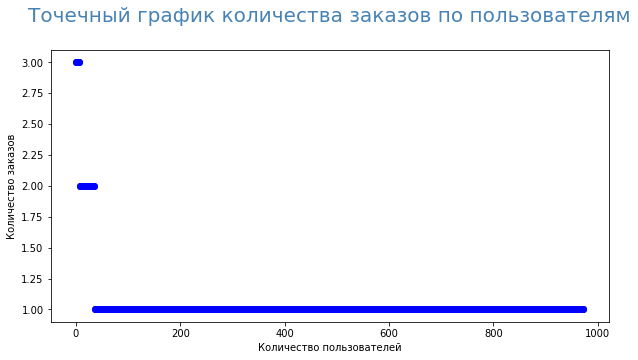

In [43]:
# построим точечную диаграмму числа заказов на одного пользователя
x_values = pd.Series(range(0,len(ordersByUsers['orders'])))

plt.figure(figsize=(10,5))
plt.scatter(x_values, ordersByUsers['orders'], c = 'b')
plt.xlabel("Количество пользователей")
plt.ylabel("Количество заказов")
plt.title('Точечный график количества заказов по пользователям' + "\n", fontsize = 20, color = 'SteelBlue');

Большинство покупателей заказывали только один раз. Точная доля пользователей с 2-3 заказами не ясна — непонятно, считать их аномалиями или нет.\
Для определения границ аномальных пользователей необходимо рассчитать выборочные перцентили количества заказов на одного пользователя.

In [44]:
# считаем 95-й и 99-й перцентили количества заказов на пользователя
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[1. 2.]


Не более 5% пользователей оформляли больше 1 заказа и 1% пользователей оформляли более 2 заказов.
Считаем разумным за верхнеюю границу числа заказов выбрать 2 заказа на одного пользователя, и отсеять аномальных пользователей по ней.

#### Точечный график стоимостей заказов, анализ аномалий

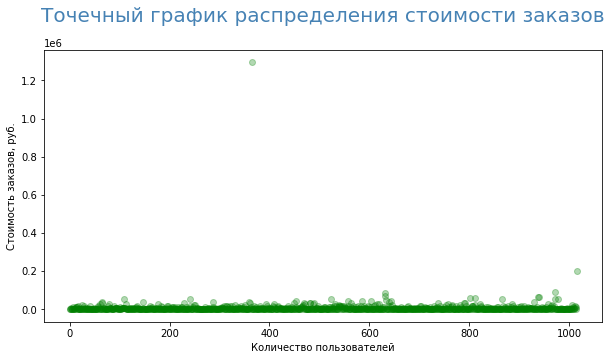

In [45]:
# построим точечную диаграмму числа заказов на одного пользователя
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(10,5))
plt.scatter(x_values, orders['revenue'], c = 'green', alpha=0.3)
plt.xlabel("Количество пользователей")
plt.ylabel("Стоимость заказов, руб.")
plt.title('Точечный график распределения стоимости заказов' + "\n", fontsize = 20, color = 'SteelBlue');

Наше предположение оказалось верным: в тестировании были дорогие заказы (200 000 и 1 300 000 рублей). Данные аномальные заказы и вызвали всплеск на графиках кумулятивных метрик. Исключим аномальные значения и построим график повторно.

In [46]:
orders.loc[orders['revenue'] == orders['revenue'].max()]

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B


Ранее мы предполагали, что всплески могу быть вызваны либо всплеском числа заказов, либопоявлением очень дорогих заказов в выборке.
Теперь, мы можем сделать обоснованный вывод, что всплески на графиках динамики кумулятивной выручки группы В обусловлены одним дорогим заказом, стоимость которого составила 1 294 500 руб (visitor_id: *1920142716*).

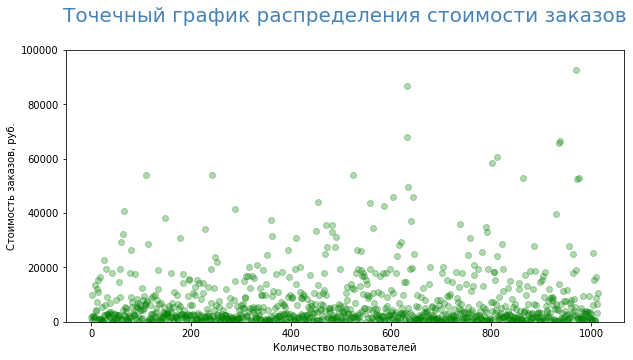

In [47]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(10,5))
# строим точечную диаграмму
plt.ylim(0, 100000)
plt.scatter(x_values, orders['revenue'], c = 'green', alpha=0.3)
plt.xlabel("Количество пользователей")
plt.ylabel("Стоимость заказов, руб.")
plt.title('Точечный график распределения стоимости заказов' + "\n", fontsize = 20, color = 'SteelBlue');

Стоимость основной массы заказов не превышала 20 000 руб. Однако, по графику мы не можем четко определить границу аномальных заказов, необходимо рассчитать выборочные перцентили.

In [48]:
# считаем 95-й и 99-й перцентили стоимости заказов на пользователя
print(np.percentile(orders['revenue'], [95, 99])) 

[26785. 53904.]


Не более, чем у 5% заказчиков чек дороже 26 785 руб, и не больше чем у 1% заказов - дороже 53 904 руб. Полагаем наиболее целесообразным исключить заказы, стоимость которых превышает 99-й перцентиль или 53 904 руб.

####  Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Чтобы рассчитать статистическую значимость различий в среднем чеке применим непараметрический тест Уилкоксона-Манна-Уитни, т.к. данные о продажах и средних чеках редко бывают нормально распределены.

Сформулируем основную и альтернативную гипотезы:\
**H0: различий в среднем количестве заказов на посетителя между группами нет,\
H1: различия в среднем количестве заказов на посетителя между группами есть.**

Установим уровень значимости равный 0.05.

##### Подготовка данных для расчета статистической значимости различий по "сырым" данным

Подготовим данные о пользователях группы А:

In [49]:
# сформируем таблицу по пользователям группы А с данными о дате и количестве пользователей в эту дату
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

In [50]:
visitorsADaily.head()

,date,visitorsPerDateA
0,2019-08-01,719
1,2019-08-02,619
2,2019-08-03,507
3,2019-08-04,717
4,2019-08-05,756


In [51]:
# выручка нарастающим итогом в разрезе пользователей
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 
         'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)

In [52]:
# переименуем столбцы
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

In [53]:
visitorsACummulative.head()

,date,visitorsCummulativeA
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845
3,2019-08-04,2562
4,2019-08-05,3318


Подготовим данные о заказах группы А:

In [54]:
# сформируем таблицу по заказам группы А с данными о дате, транзакциях, идентификатор пользователя, выручке
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg(
        {'transaction_id': pd.Series.nunique, 
         'revenue': 'sum'}
    )
)

In [55]:
# переименуем столбцы
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

In [56]:
ordersADaily.head()

,date,ordersPerDateA,revenuePerDateA
0,2019-08-01,23,142779
1,2019-08-02,19,91602
2,2019-08-03,24,112473
3,2019-08-04,11,41176
4,2019-08-05,22,86383


In [57]:
# выручка нарастающим итогом в разрезе заказов
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 
         'ordersPerDateA': 'sum', 
         'revenuePerDateA': 'sum'
        }
    ),
    axis=1,
).sort_values(by=['date'])

In [58]:
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

In [59]:
ordersACummulative.head()

,date,ordersCummulativeA,revenueCummulativeA
0,2019-08-01,23,142779
1,2019-08-02,42,234381
2,2019-08-03,66,346854
3,2019-08-04,77,388030
4,2019-08-05,99,474413


Подготовим данные о пользователях группы В:

In [60]:
# сформируем таблицу по пользователям группы В с данными о дате и количестве пользователей
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

In [61]:
visitorsBDaily.head()

,date,visitorsPerDateB
31,2019-08-01,713
32,2019-08-02,581
33,2019-08-03,509
34,2019-08-04,770
35,2019-08-05,707


In [62]:
# выручка нарастающим итогом в разрезе пользователей
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)

In [63]:
# переименуем столбцы
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [64]:
visitorsBCummulative.head()

,date,visitorsCummulativeB
31,2019-08-01,713
32,2019-08-02,1294
33,2019-08-03,1803
34,2019-08-04,2573
35,2019-08-05,3280


Подготовим данные о заказах группы В:

In [65]:
# сформируем таблицу по заказам группы В с данными о дате, транзакциях, идентификатор пользователя, выручке
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)

In [66]:
# переименуем столбцы
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

In [67]:
ordersBDaily.head()

,date,ordersPerDateB,revenuePerDateB
0,2019-08-01,17,59758
1,2019-08-02,23,162043
2,2019-08-03,14,67049
3,2019-08-04,14,96890
4,2019-08-05,21,89908


In [68]:
# выручка нарастающим итогом в разрезе заказов
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 
         'ordersPerDateB': 'sum', 
         'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

In [69]:
ordersBCummulative.head()

,date,ordersPerDateB,revenuePerDateB
0,2019-08-01,17,59758
1,2019-08-02,40,221801
2,2019-08-03,54,288850
3,2019-08-04,68,385740
4,2019-08-05,89,475648


##### Создание таблиц с данными о количестве заказов в разрезе пользователей, которые оформляли хотя бы 1 заказ

In [70]:
# таблица с данными о количестве заказов в разрезе пользователей группы А
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)

In [71]:
# переименуем столбцы
ordersByUsersA.columns = ['buyers_id', 'orders']

In [72]:
ordersByUsersA.sort_values(by='orders', ascending = False).head(6)

,buyers_id,orders
58,611059232,3
211,2108163459,3
310,2988190573,3
409,3908431265,3
416,3967698036,3
302,2892265953,2


In [73]:
# таблица с данными о количестве заказов в разрезе пользователей группы В
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)

In [74]:
# переименуем столбцы
ordersByUsersB.columns = ['buyers_id', 'orders']

In [75]:
ordersByUsersB.sort_values(by='orders', ascending = False).head(6)

,buyers_id,orders
347,2742574263,3
33,249864742,3
486,3935952912,2
256,2025197455,2
418,3332057097,2
51,406208401,2


#####  Подготовка выборок к проверке критерием Манна-Уитни

Для каждой группы объявим переменные `sampleA` и `sampleB`, в которых помимо пользователей, совершивших 1 заказ и более, будут добавлены пользователи, которые не сделали ни одного заказа:

> **Группа А:**

In [76]:
# список с количеством заказов для каждого из пользователей
ordersByUsersA['orders']

0      1
1      1
2      1
3      1
4      1
      ..
440    1
441    1
442    1
443    1
444    1
Name: orders, Length: 445, dtype: int64

In [77]:
# количество пользователей, которые не совершили ни одного заказа
print(f"количество пользователей, которые не совершили ни одного заказа \
{visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])}")

количество пользователей, которые не совершили ни одного заказа 18291


In [78]:
# объединим последовательности количества заказов в разрезе пользователей без заказов и с заказами
sampleA = pd.concat(
    [ordersByUsersA['orders'],
     pd.Series(0, index=np.arange(visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')]
    ,axis=0)

In [79]:
sampleA.count()

18736

> **Группа B:**

In [80]:
# список с количеством заказов для каждого из пользователей
ordersByUsersB['orders']

0      1
1      1
2      1
3      1
4      1
      ..
523    1
524    1
525    1
526    1
527    1
Name: orders, Length: 528, dtype: int64

In [81]:
# количество пользователей, которые не совершили ни одного заказа
print(f"количество пользователей, которые не совершили ни одного заказа \
{visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])}")

количество пользователей, которые не совершили ни одного заказа 18388


In [82]:
# объединим последовательности количества заказов в разрезе пользователей без заказов и с заказами
sampleB = pd.concat(
    [ordersByUsersB['orders'],
     pd.Series(0, index=np.arange(visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')]
    ,axis=0)

In [83]:
sampleB.count()

18916

In [84]:
print(f"Количество пользователей в группах отличается на \
{round((sampleB.count() - sampleA.count()) / sampleA.count() * 100, 2)}%")

Количество пользователей в группах отличается на 0.96%


Вывод: Количество пользователей в различных группах различается не более, чем на 1% => не окажет существенного влияния на тест.

#####  Непараметрический тест Манна-Уитни

In [85]:
alpha = 0.05
p_value = stats.mannwhitneyu(sampleA, sampleB)[1]

if (p_value < alpha):
    print(f"p_value = {'{0:.3f}'.format(p_value)} => Отвергаем нулевую гипотезу")
else:
    print(f"p_value = {'{0:.3f}'.format(p_value)} => Не получилось отвергнуть нулевую гипотезу")

p_value = 0.011 => Отвергаем нулевую гипотезу


In [86]:
# относительный прирост среднего количества заказов группы B к группе А
convers = round(
    (
    (ordersBDaily['ordersPerDateB'].sum() / visitorsBDaily['visitorsPerDateB'].sum())/\
    (ordersADaily['ordersPerDateA'].sum() / visitorsADaily['visitorsPerDateA'].sum()) - 1
    ) * 100,
    2
)

In [87]:
if (convers < 0):
    print(f"Относительный проигрыш группы B равен {'{0:.2f}'.format(convers)}%")
else:
    print(f"Относительный прирост среднего количества заказов группы В к группе А равен \
{'{0:.2f}'.format(convers)}%")

Относительный прирост среднего количества заказов группы В к группе А равен 15.98%


**Вывод:**
* выявлено статистически значимое различие по среднему количеству заказов между группами по «сырым»;
* среднее количество заказов группы В превышает среднее группы А на 15,98% => результаты группу В лучше.

#### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

**Нулевая гипотеза:** различий в среднем чеке между группами нет.\
**Альтернативная гипотеза:** различия в среднем чеке между группами есть. 

Чтобы рассчитать статистическую значимость различий в среднем чеке - необходимо передать критерию *mannwhitneyu()* данные о выручке с заказов:

In [88]:
# выборка по сырым данным для пользователей группы А
sampeArev = orders[orders['group']=='A']['revenue']

In [89]:
# выборка по сырым данным для пользователей группы B
sampeBrev = orders[orders['group']=='B']['revenue']

In [90]:
alpha = 0.05
p_value = stats.mannwhitneyu(sampeArev, sampeBrev)[1]

if (p_value < alpha):
    print(f"p_value = {'{0:.3f}'.format(p_value)} => Отвергаем нулевую гипотезу")
else:
    print(f"p_value = {'{0:.3f}'.format(p_value)} => Не получилось отвергнуть нулевую гипотезу")

p_value = 0.829 => Не получилось отвергнуть нулевую гипотезу


In [91]:
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.287


**Вывод:**
* P-value больше 0.05 - статистически значимых отличий в среднем чеке по "сырым" данным между группами нет. 
* Относительное различие среднего чека между сегментами 28,7%.\
  Существенная относительная разница при отсутствии статистической значимости указывает на влияние выбросов на метрику. Полагаем, что группа В имеет аномально дорогие заказы.

####  Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

За верхнеюю границу числа заказов мы выбрали 99-й перцентиль: 2 заказа на одного пользователя;\
Исключаем заказы, стоимость которых превышает 99-й перцентиль или 53 904 руб.

##### Создание таблиц с аномальными данными о количестве и сумме заказов на 1 пользователя

In [92]:
# верхняя границы выручки
perc99_revenue = np.percentile(orders['revenue'], 99)
perc99_revenue

53904.0

In [93]:
# верхняя границы числа заказов на 1 пользователя
perc99_orders = np.percentile(ordersByUsers['orders'], 99)
perc99_orders

2.0

In [94]:
#  сделаем срезы пользователей с числом заказов больше 2
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > perc99_orders]['buyers_id'],
        ordersByUsersB[ordersByUsersB['orders'] > perc99_orders]['buyers_id'],
    ],
    axis=0,
)
usersWithManyOrders

58     611059232 
211    2108163459
310    2988190573
409    3908431265
416    3967698036
33     249864742 
347    2742574263
Name: buyers_id, dtype: int64

In [95]:
# сделаем срезы пользователей со стоимостью заказа больше 53 904 руб.
usersWithExpensiveOrders = orders[orders['revenue'] > perc99_revenue]['visitor_id']
usersWithExpensiveOrders

425     1920142716
743     4133034833
744     888512513 
940     4003628586
949     887908475 
1099    148427295 
1103    1164614297
1136    1307669133
1196    2108080724
Name: visitor_id, dtype: int64

In [96]:
# объединим данные об аномальных пользователях в одну таблицу
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
)
abnormalUsers

58      611059232 
211     2108163459
310     2988190573
409     3908431265
416     3967698036
33      249864742 
347     2742574263
425     1920142716
743     4133034833
744     888512513 
940     4003628586
949     887908475 
1099    148427295 
1103    1164614297
1136    1307669133
1196    2108080724
dtype: int64

##### Подготовка выборок с очищенными данными о заказах — не включая аномальных пользователей

In [97]:
# выборка с данными о заказах для группы А
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['buyers_id'].isin(abnormalUsers))
        ]['orders'],
        # добавляем пользователей без заказов
        pd.Series(
            0,
            index=np.arange(
                visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
sampleAFiltered.head()

0    1
1    1
2    1
3    1
4    1
Name: orders, dtype: int64

In [98]:
# выборка с данными о заказах для группы В
sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['buyers_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 
sampleBFiltered.head()

0    1
1    1
2    1
3    1
4    1
Name: orders, dtype: int64

In [99]:
print(f"Количество пользователей в группах отличается на \
{round((sampleBFiltered.count() - sampleAFiltered.count()) / sampleAFiltered.count() * 100, 2)}%")

Количество пользователей в группах отличается на 0.98%


Вывод: Количество пользователей в различных группах различается не более, чем на 1% => не окажет существенного влияния на тест.

##### Непараметрический тест Манна-Уитни

**Нулевая гипотеза:** различий в среднем количестве заказов на посетителя между группами нет,\
**Альтернативная гипотеза:** различия в среднем количестве заказов на посетителя между группами есть.

In [100]:
alpha = 0.05
p_value = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]

if (p_value < alpha):
    print(f"p_value = {'{0:.3f}'.format(p_value)} => Отвергаем нулевую гипотезу")
else:
    print(f"p_value = {'{0:.3f}'.format(p_value)} => Не получилось отвергнуть нулевую гипотезу")

p_value = 0.007 => Отвергаем нулевую гипотезу


In [101]:
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.189


Как и в случае с "сырыми" данными статистическая значимость достигнута. Показатель среднего количества заказов группы В значительно превышает аналогичный показатель группы А.

##### График различия среднего количества заказов между группами ("очищенные данные")

###### Подготовка агрегированных очищенных данных

Соберём агрегированные кумулятивные "очищенные" данные о заказах по дням:

In [102]:
# для построения графика отличия средних чеков/заказов уберем аномальные значения из таблицы заказов группа А
orders_normal = orders.query('visitor_id not in @abnormalUsers')
orders_normal.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


In [103]:
datesGroups_normal = orders_normal[['date','group']].drop_duplicates() 

In [104]:
ordersAggregated_normal = (
    datesGroups_normal
    .apply(
        lambda x: orders_normal[np.logical_and(orders_normal['date'] <= x['date'], orders_normal['group'] == x['group'])]
        .agg(
            {
                'date' : 'max', 
                'group' : 'max', 
                'transaction_id' : 'nunique', 
                'visitor_id' : 'nunique', 
                'revenue' : 'sum'
            }
        ), axis=1)
    .sort_values(by=['date','group'])
)

Аналогично получим "очищенные" агрегированные кумулятивные по дням данные о посетителях интернет-магазина:

In [105]:
visitorsAggregated_normal = (
    datesGroups_normal
    .apply(
        lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
        .agg(
            {
                'date' : 'max', 
                'group' : 'max', 
                'visitors' : 'sum'
            }
        ), axis = 1)
)

In [106]:
# объединим таблицы
cumulativeData_normal = (
    ordersAggregated_normal.merge(visitorsAggregated_normal, left_on=['date', 'group'], right_on=['date', 'group'])
)
cumulativeData_normal = cumulativeData_normal.rename(columns = {'transaction_id': 'orders', 'visitor_id': 'buyers'})
cumulativeData_normal.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,18,17,112340,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,36,34,202252,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,60,58,314725,1845


In [107]:
# считаем кумулятивное среднее количество заказов по очищенным данным
cumulativeData_normal['conversion'] = cumulativeData_normal['orders']/cumulativeData_normal['visitors']

# отделяем данные по группе A
cumulativeDataA_normal = cumulativeData_normal[cumulativeData_normal['group']=='A']

# отделяем данные по группе B
cumulativeDataB_normal = cumulativeData_normal[cumulativeData_normal['group']=='B']

In [108]:
# объединим информацию о среднем количестве заказов группы А и В в одну таблицу
mergedCumulativeConversions_normal = (
    cumulativeDataA_normal[['date','conversion']]
    .merge(cumulativeDataB_normal[['date','conversion']], 
           left_on='date', 
           right_on='date', 
           how='left', 
           suffixes=['A', 'B'])

)

######  График различия среднего количества заказов по данным "очищенных" и "сырых" данных

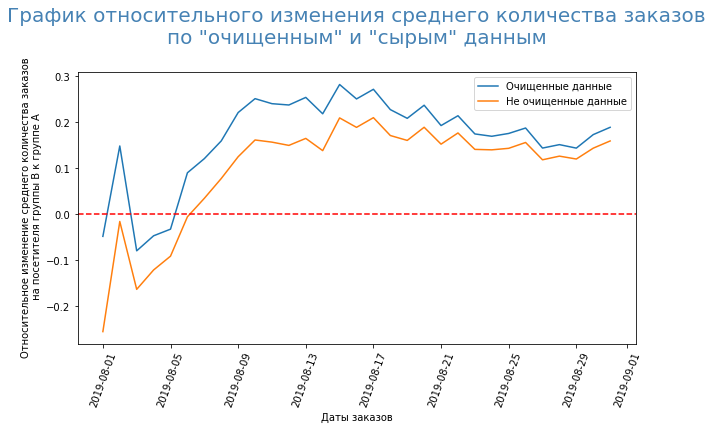

In [109]:
plt.figure(figsize=(10,5))
plt.plot(mergedCumulativeConversions_normal['date'], 
         mergedCumulativeConversions_normal['conversionB']/mergedCumulativeConversions_normal['conversionA']-1, 
         label="Очищенные данные")
plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, 
         label="Не очищенные данные")
plt.xticks(rotation=70)
plt.xlabel("Даты заказов")
plt.ylabel("Относительное изменение среднего количества заказов" + "\n" + " на посетителя группы В к группе А")
plt.title('График относительного изменения среднего количества заказов' + "\n" + 'по "очищенным" и "сырым" данным' + "\n", 
          fontsize = 20, color = 'SteelBlue')
plt.axhline(y=0, color='red', linestyle='--')
plt.legend()
plt.show()

**Вывод:**\
Результаты по среднему количеству заказов практически не изменились:
* как и в случае с "сырыми" данными статистическая значимость достигнута.
* несущественно увеличился относительный средний прирост заказов группы В к группе А с 15,98% до 18,9%. 

Группа В значительно лучше группы А по среднему количеству заказов.

#### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

##### Подготовка выборок с очищенными данными о стоимости заказов — не включая аномальных пользователей

In [110]:
# выборка с данными о выручке для группы А
sampleAFiltered_rev = (
    orders[
        np.logical_and(
            orders['group'] == 'A',
            np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
        )
    ]['revenue']
)

In [111]:
# выборка с данными о выручке для группы В
sampleBFiltered_rev = (
    orders[
        np.logical_and(
            orders['group'] == 'B',
            np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
        )
    ]['revenue']
)

##### Непараметрический тест Манна-Уитни

**Нулевая гипотеза:** различий в среднем чеке между группами нет.\
**Альтернативная гипотеза:** различия в среднем чеке между группами есть.

In [112]:
alpha = 0.05
p_value = stats.mannwhitneyu(sampleAFiltered_rev, sampleBFiltered_rev)[1]

if (p_value < alpha):
    print(f"p_value = {'{0:.3f}'.format(p_value)} => Отвергаем нулевую гипотезу")
else:
    print(f"p_value = {'{0:.3f}'.format(p_value)} => Не получилось отвергнуть нулевую гипотезу")

p_value = 0.788 => Не получилось отвергнуть нулевую гипотезу


In [113]:
print(f"Oтносительный прирост среднего чека очищенной группы B к группе А \
{'{0:.2f}'.format((sampleBFiltered_rev.mean()/sampleAFiltered_rev.mean()-1) * 100)}%") 

Oтносительный прирост среднего чека очищенной группы B к группе А -3.23%


##### График кумулятивной выручки по группам ("очищенные" данные)

In [114]:
# стоимость заказов в разрезе групп
cumulativeRevenueA_normal = cumulativeData_normal[cumulativeData_normal['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB_normal = cumulativeData_normal[cumulativeData_normal['group']=='B'][['date','revenue', 'orders']]

In [115]:
# собираем очищенные данные о выручке для группы А и В в одном датафрейме
mergedCumulativeRevenue_normal = (
    cumulativeRevenueA_normal
    .merge(
        cumulativeRevenueB_normal, 
        left_on='date', 
        right_on='date', 
        how='left', 
        suffixes=['A', 'B'])
)

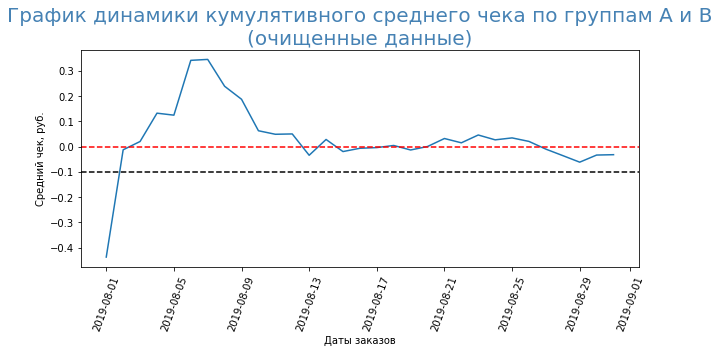

In [116]:
# cтроим отношение средних чеков
plt.figure(figsize=(10,4))

plt.plot(
    mergedCumulativeRevenue_normal['date'], 
    (mergedCumulativeRevenue_normal['revenueB']/mergedCumulativeRevenue_normal['ordersB'])
    /(mergedCumulativeRevenue_normal['revenueA']/mergedCumulativeRevenue_normal['ordersA'])
    -1
)

plt.axhline(y=0, color='red', linestyle='--')
plt.axhline(y=-0.1, color='black', linestyle='--')
plt.xticks(rotation=70)
plt.xlabel("Даты заказов")
plt.ylabel("Средний чек, руб.")
plt.title('График динамики кумулятивного среднего чека по группам А и В' + "\n" + '(очищенные данные)', fontsize = 20, color = 'SteelBlue');

График различия среднего чека говорит о том, что средний чек группы B падает по отношению к группе А после явного скачка. И после этого падения он колеблется около нуля.\
К концу теста средний чек группы В хуже, чем у группы А, почти на 10%.

**Вывод:**\
После очистки выборок от аномалий, разница средних чеков между группами существенно сократилась с 29% до -3% => аномалии существенно повлияли на результаты A/B-теста. Однако, как и в случае с "сырыми" данными статистическая значимость не достигнута.

### Решение по результатам теста

Подытожим имеющиеся факты

**Среднее количество заказов:**
- Есть статистически значимое различие по среднему количеству заказов между группами как по «сырым», так и по данным после фильтрации аномалий =>
 > есть различия среднего количества заказов на посетителя между группами. Группа В опережает группу А на 15% ("сырые" данные") и 18% ("Очищенные" данные)
- График различия среднего количества заказов между группами демонстрирует, что результаты группы B лучше группы A,  направленность к падению не обнаружена. 

**Средний чек:**
- Нет статистически значимого различия по среднему чеку между группами как по «сырым», так и по данным после фильтрации аномалий =>
 >  различия в среднем чеке между группами нет (-3% "очищенные" данные)
- График различия среднего чека между группами показывает, что к концу теста результаты группы B хуже группы A и нет значительной тенденции к улучшению.

**Вывод:**
>Исходя из обнаруженных фактов, тест следует остановить и признать его успешным. Продолжать смысла нет, потому как есть существенная вероятность, что при имеющихся данных сегмент B на самом деле лучше сегмента A и приведет к увеличению выручки.\
Доход будет выше в связи с тем, что рост количества заказов существенно опережает снижение среднего чека.

Рост числа заказов с одновременным снижением среднего чека может быть обусловлен следующими факторами:
- покупатели стали дробить заказы,
- приход на рынок конкурентов с недорогими товарами (рост конкуренции),
- интернет-магазин злоупотребляет акциями на товары (агрессивный маркетинг),
- падение доходов населения.

**Рекомендации:**\
по нашему мнению необходимо обратить внимание и проработать мероприятия для увеличения среднего чека:
1. оценить эффект от промоактивностей (приносить ли акция прибыль, оценить конверсию посетителей в покупателей). Возможно, следует сократить/изменить часть акций,
2. рассмотреть озможность замены акция на программу лояльности - заменить скидки на накопительные бонусы,
3. есть ли на сайте раздел "Рекомендуемые товары". Если нет, то оценить трудозатраты по его добавлению. Если есть, то проанализировать:
     * местоположение раздела на сайте (легко заметно/ трудно обнаружить)
     * насколько активно приобретают товары из этого раздела. При необходимости изменить перечень рекомендуемых товаров
     * добавить в раздел не единичные товары, а комплекты (увеличит товарооборот, чек). Например, к "ходовому" товару добавить менее ходовую продукцию.
4. разделить покупателей на сегоменты, достаточная ли работа проводится с наиболее активными клиентами для увеличению продаж.